In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd

# ============================================================
# Settings
# ============================================================
VEXT_MAX = 10.1
VEXT_MIN = -15
N_BINS   = 20

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")  # Strukturkürzel + Temperatur

# ============================================================
# Boltzmann-factor histogram with LOG-spaced bins in b-space
#   x = beta Vext (reduced external potential)
#   b = exp(-x)   (Boltzmann factor, physically typical)
# ============================================================
def make_boltzmann_edges_log(vmin, vmax, n_bins):
    """
    Build log-spaced bin edges in Boltzmann-factor space b = exp(-x),
    corresponding to x in [vmin, vmax].
    """
    # b-range from x-range; note exp(-x) flips ordering
    b1 = np.exp(-vmin)
    b2 = np.exp(-vmax)
    bmin, bmax = (min(b1, b2), max(b1, b2))

    # log-spaced edges (strictly positive)
    edges = np.logspace(np.log10(bmin), np.log10(bmax), n_bins + 1)
    return edges

def make_boltzmann_edges_linear(vmin, vmax, n_bins):
    """
    Build linearly spaced bin edges in Boltzmann-factor space b = exp(-x),
    corresponding to x in [vmin, vmax].
    """
    # b-range from x-range
    b1 = np.exp(-vmin)
    b2 = np.exp(-vmax)
    bmin, bmax = (min(b1, b2), max(b1, b2))

    edges = np.linspace(bmin, bmax, n_bins + 1)
    return edges

def make_x_edges_linear(vmin, vmax, n_bins):
    """
    Build linearly spaced bin edges directly in x = beta Vext space.
    No Boltzmann factor involved.
    """
    edges = np.linspace(vmin, vmax, n_bins + 1)
    return edges

def histogram_x(arr_x, vmin, vmax, n_bins):
    """
    Histogram directly in x-space.
    """
    edges = make_x_edges_linear(vmin, vmax, n_bins)
    hist, _ = np.histogram(arr_x, bins=edges)
    return hist, edges 

def boltzmann_hist_logbins(arr_x, vmin, vmax, n_bins):
    """
    arr_x: reduced potential array x = beta Vext
    Returns histogram counts in log-spaced b=exp(-x) bins + edges.
    """
    # Clean + clip in x-space (same as before)
    x = np.asarray(arr_x, dtype=np.float64).squeeze()
    x = x[np.isfinite(x)]
    x = np.clip(x, vmin, vmax)

    # Transform to Boltzmann factor
    b = np.exp(-x)

    # Build log-bins in b-space
    edges = make_boltzmann_edges_log(vmin, vmax, n_bins)

    # Histogram in b-space
    hist, edges = np.histogram(b, bins=edges)
    return hist, edges


# ============================================================
# Collect
# ============================================================
all_dfs = []
counter_badshape = 0

for temp_folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, temp_folder)

    # only folders starting with "Vext_" (e.g., Vext_298)
    if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
        continue

    print(f"\nBearbeite Temperatur-Ordner: {temp_folder}")
    rows = []

    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        m = pattern.match(filename)
        if not m:
            print(f"Übersprungen (kein gültiger Name): {filename}")
            continue

        struct_name, temp = m.groups()
        temp_k = float(temp)
        file_path = os.path.join(temp_path, filename)

        # Load
        with open(file_path, "rb") as f:
            data = pickle.load(f)

        # Optional shape check BEFORE clipping (same behavior as your code)
        arr_raw = np.asarray(data, dtype=np.float64).squeeze()
        arr_raw = arr_raw[np.isfinite(arr_raw)]
        if arr_raw.size != 64**3:
            counter_badshape += 1  # info/debug only

        # Boltzmann histogram (log-spaced bins in b-space)
        hist, edges = boltzmann_hist_logbins(arr_raw, VEXT_MIN, VEXT_MAX, N_BINS)

        # Store BOTH the b-space edges (optional) and x-range (for traceability)
        # Note: edges are in b-space (Boltzmann factor), not in x-space!
        entry = {
            "structure_name": struct_name,
            "temperature_kelvin": temp_k,

            # histogram counts
            **{f"bin_{i}": int(v) for i, v in enumerate(hist)},

            # store b-range that defines the histogram
            "b_min": float(edges[0]),
            "b_max": float(edges[-1]),

            # also store x-range used for clipping (useful metadata)
            "x_clip_min": float(VEXT_MIN),
            "x_clip_max": float(VEXT_MAX),
        }

        # (Optional) If you want to store edges explicitly as columns:
        # for i, e in enumerate(edges):
        #     entry[f"edge_{i}"] = float(e)

        rows.append(entry)

    if rows:
        df_temp = pd.DataFrame(rows)
        all_dfs.append(df_temp)
        print(f"{len(rows)} Strukturen verarbeitet")

# ============================================================
# Merge + Save
# ============================================================
df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

print(f"\nGesamt-DataFrame mit {len(df_all)} Zeilen erstellt")
print(f"Anzahl Dateien mit unerwarteter Größe: {counter_badshape}")

out_name = "Boltzmann_allTEMP_hist_logbins_20b_FINALE.csv"
out_path = os.path.join("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/", out_name)

df_all.to_csv(out_path, index=False)
print(f"Datei gespeichert unter:\n{out_path}")


In [49]:
import os
import re
import pickle
import numpy as np
import pandas as pd

# ============================================================
# Settings
# ============================================================
VEXT_MAX = 10.1
VEXT_MIN = -15
N_BINS   = 20

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/"
out_dir  = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")  # Strukturkürzel + Temperatur

# Choose ONE mode per run (will auto-name the CSV accordingly)
# Modes:
#   "x_linear"     -> x = beta Vext, linear bins in x-space
#   "x_log"        -> x = beta Vext, shifted-log bins in x-space (works for vmin<=0)
#   "bolt_linear"  -> b = exp(-x), linear bins in b-space
#   "bolt_log"     -> b = exp(-x), log bins in b-space
MODE = "x_linear"

# ============================================================
# Edge builders
# ============================================================
def make_boltzmann_edges_log(vmin, vmax, n_bins):
    b1 = np.exp(-vmin)
    b2 = np.exp(-vmax)
    bmin, bmax = (min(b1, b2), max(b1, b2))
    return np.logspace(np.log10(bmin), np.log10(bmax), n_bins + 1)

def make_boltzmann_edges_linear(vmin, vmax, n_bins):
    b1 = np.exp(-vmin)
    b2 = np.exp(-vmax)
    bmin, bmax = (min(b1, b2), max(b1, b2))
    return np.linspace(bmin, bmax, n_bins + 1)

def make_x_edges_linear(vmin, vmax, n_bins):
    return np.linspace(vmin, vmax, n_bins + 1)

def make_x_edges_log(vmin, vmax, n_bins, eps=1e-12):
    """
    Log-spaced edges in x-space even if vmin<=0 by shifting:
      x' = x - vmin + eps > 0
    """
    span = vmax - vmin
    if span <= 0:
        raise ValueError("vmax must be > vmin")
    edges_shifted = np.logspace(np.log10(eps), np.log10(span + eps), n_bins + 1)
    edges_x = edges_shifted + vmin - eps
    edges_x[0] = vmin
    edges_x[-1] = vmax
    return edges_x

# ============================================================
# Histogram functions (return hist, edges, meta)
# ============================================================
def x_hist_linearbins(arr_x, vmin, vmax, n_bins):
    x = np.asarray(arr_x, dtype=np.float64).squeeze()
    x = x[np.isfinite(x)]
    x = np.clip(x, vmin, vmax)
    edges = make_x_edges_linear(vmin, vmax, n_bins)
    hist, edges = np.histogram(x, bins=edges)
    meta = {"space": "x", "binning": "linear", "x_clip_min": float(vmin), "x_clip_max": float(vmax)}
    return hist, edges, meta

def x_hist_logbins(arr_x, vmin, vmax, n_bins):
    x = np.asarray(arr_x, dtype=np.float64).squeeze()
    x = x[np.isfinite(x)]
    x = np.clip(x, vmin, vmax)
    edges = make_x_edges_log(vmin, vmax, n_bins)
    hist, edges = np.histogram(x, bins=edges)
    meta = {"space": "x", "binning": "log", "x_clip_min": float(vmin), "x_clip_max": float(vmax)}
    return hist, edges, meta

def bolt_hist_linearbins(arr_x, vmin, vmax, n_bins):
    x = np.asarray(arr_x, dtype=np.float64).squeeze()
    x = x[np.isfinite(x)]
    x = np.clip(x, vmin, vmax)
    b = np.exp(-x)
    edges = make_boltzmann_edges_linear(vmin, vmax, n_bins)
    hist, edges = np.histogram(b, bins=edges)
    meta = {
        "space": "bolt",
        "binning": "linear",
        "b_min": float(edges[0]),
        "b_max": float(edges[-1]),
        "x_clip_min": float(vmin),
        "x_clip_max": float(vmax),
    }
    return hist, edges, meta

def bolt_hist_logbins(arr_x, vmin, vmax, n_bins):
    x = np.asarray(arr_x, dtype=np.float64).squeeze()
    x = x[np.isfinite(x)]
    x = np.clip(x, vmin, vmax)
    b = np.exp(-x)
    edges = make_boltzmann_edges_log(vmin, vmax, n_bins)
    hist, edges = np.histogram(b, bins=edges)
    meta = {
        "space": "bolt",
        "binning": "log",
        "b_min": float(edges[0]),
        "b_max": float(edges[-1]),
        "x_clip_min": float(vmin),
        "x_clip_max": float(vmax),
    }
    return hist, edges, meta

HIST_MODES = {
    "x_linear": x_hist_linearbins,
    "x_log": x_hist_logbins,
    "bolt_linear": bolt_hist_linearbins,
    "bolt_log": bolt_hist_logbins,
}

if MODE not in HIST_MODES:
    raise ValueError(f"Unknown MODE '{MODE}'. Choose from {list(HIST_MODES.keys())}")

# ============================================================
# Collect
# ============================================================
all_dfs = []
counter_badshape = 0

for temp_folder in os.listdir(base_dir):
    temp_path = os.path.join(base_dir, temp_folder)

    if not (os.path.isdir(temp_path) and temp_folder.startswith("Vext_")):
        continue

    print(f"\nBearbeite Temperatur-Ordner: {temp_folder}")
    rows = []

    for filename in os.listdir(temp_path):
        if not filename.endswith(".pkl"):
            continue

        m = pattern.match(filename)
        if not m:
            print(f"Übersprungen (kein gültiger Name): {filename}")
            continue

        struct_name, temp = m.groups()
        temp_k = float(temp)
        file_path = os.path.join(temp_path, filename)

        with open(file_path, "rb") as f:
            data = pickle.load(f)

        arr_raw = np.asarray(data, dtype=np.float64).squeeze()
        arr_raw = arr_raw[np.isfinite(arr_raw)]
        if arr_raw.size != 64**3:
            counter_badshape += 1

        hist, edges, meta = HIST_MODES[MODE](arr_raw, VEXT_MIN, VEXT_MAX, N_BINS)

        entry = {
            "structure_name": struct_name,
            "temperature_kelvin": temp_k,
            **{f"bin_{i}": int(v) for i, v in enumerate(hist)},
            **meta,
        }
        rows.append(entry)

    if rows:
        all_dfs.append(pd.DataFrame(rows))
        print(f"{len(rows)} Strukturen verarbeitet")

# ============================================================
# Merge + Save (auto-named)
# ============================================================
df_all = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
print(f"\nGesamt-DataFrame mit {len(df_all)} Zeilen erstellt")
print(f"Anzahl Dateien mit unerwarteter Größe: {counter_badshape}")

space_tag = "x" if MODE.startswith("x_") else "bolt"
bin_tag   = "log" if MODE.endswith("_log") else "linear"
out_name  = f"Hist_{space_tag}_{bin_tag}_{N_BINS}b_FINALE.csv"
out_path  = os.path.join(out_dir, out_name)

df_all.to_csv(out_path, index=False)
print(f"Datei gespeichert unter:\n{out_path}")



Bearbeite Temperatur-Ordner: Vext_400
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_348
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_300
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_298
245 Strukturen verarbeitet

Bearbeite Temperatur-Ordner: Vext_373
245 Strukturen verarbeitet

Gesamt-DataFrame mit 1225 Zeilen erstellt
Anzahl Dateien mit unerwarteter Größe: 0
Datei gespeichert unter:
/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Hist_x_linear_20b_FINALE.csv


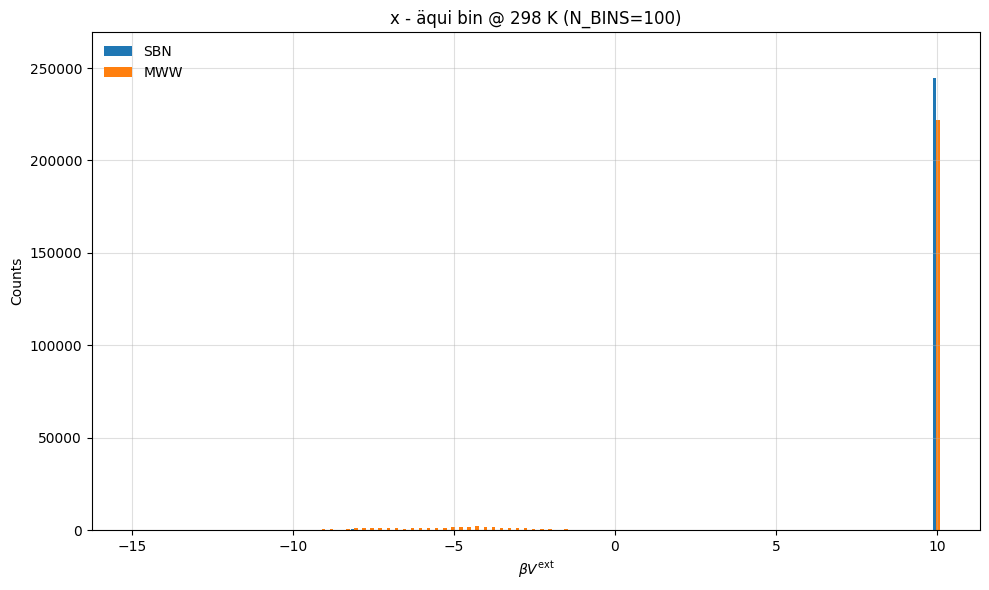

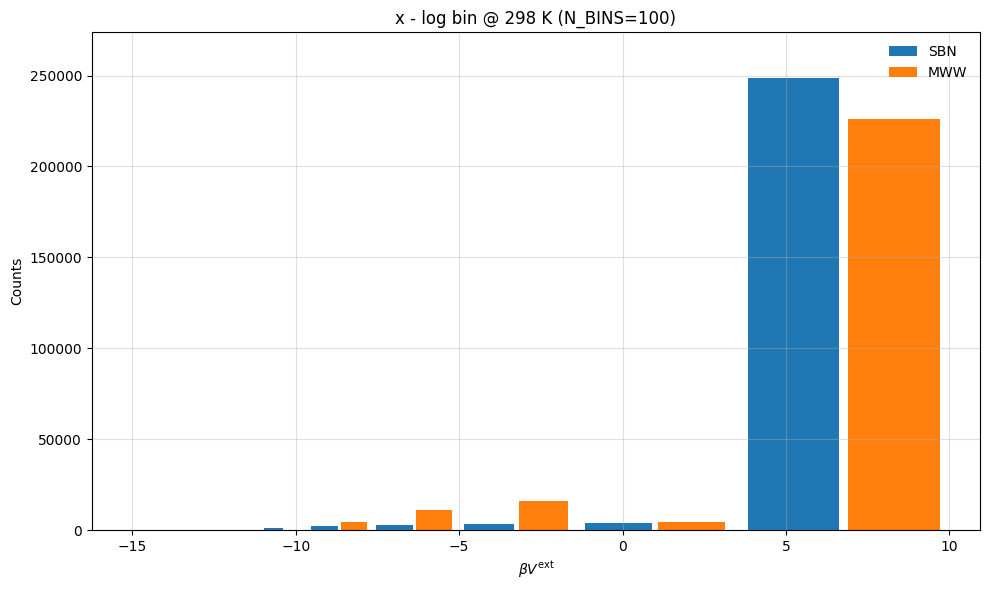

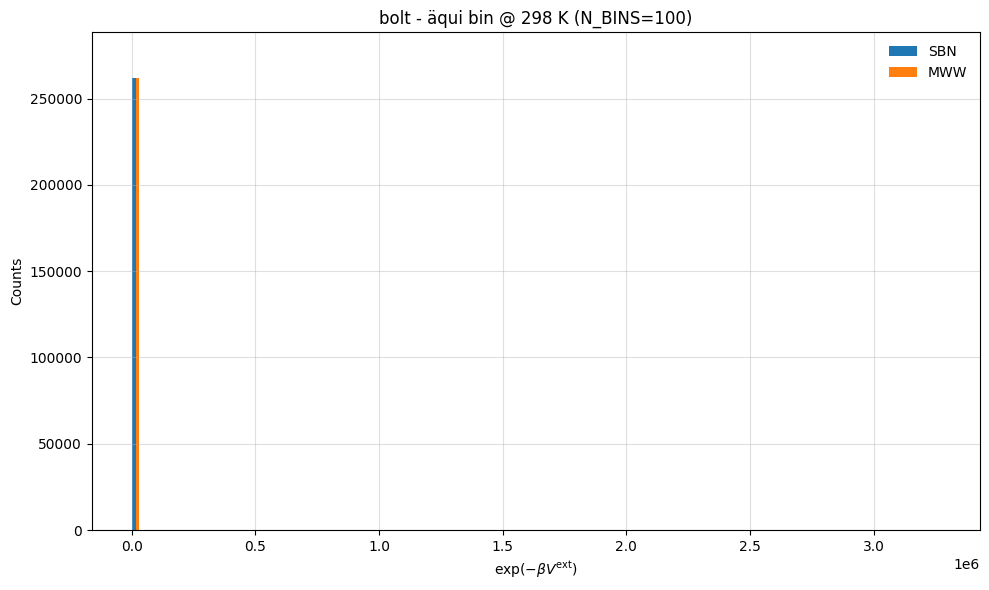

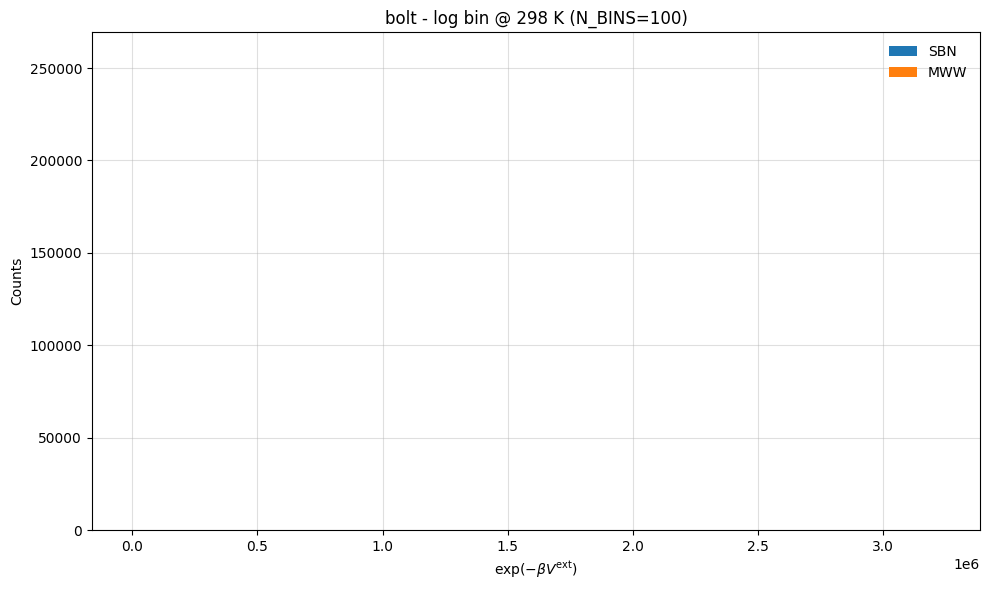

In [47]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Settings
# ============================================================
VEXT_MAX = 10.1
VEXT_MIN = -15
N_BINS   = 100

base_dir = "/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_64grid_swing/"
pattern  = re.compile(r"Vext_([A-Z]{3})_(\d+)\.pkl")

TARGET_TEMP_K = 298          # <- welche Temperatur soll geplottet werden?
STRUCTS = ["SBN", "MWW"]     # <- genau diese beiden

# ============================================================
# Edge builders
# ============================================================
def make_boltzmann_edges_log(vmin, vmax, n_bins):
    b1 = np.exp(-vmin)
    b2 = np.exp(-vmax)
    bmin, bmax = (min(b1, b2), max(b1, b2))
    return np.logspace(np.log10(bmin), np.log10(bmax), n_bins + 1)

def make_boltzmann_edges_linear(vmin, vmax, n_bins):
    b1 = np.exp(-vmin)
    b2 = np.exp(-vmax)
    bmin, bmax = (min(b1, b2), max(b1, b2))
    return np.linspace(bmin, bmax, n_bins + 1)

def make_x_edges_linear(vmin, vmax, n_bins):
    return np.linspace(vmin, vmax, n_bins + 1)

def make_x_edges_log(vmin, vmax, n_bins, eps=1e-12):
    """
    Shifted-log binning for x-space (works for vmin<=0):
      x' = x - vmin + eps > 0, do logspace in x', map back.
    """
    span = vmax - vmin
    if span <= 0:
        raise ValueError("vmax must be > vmin")
    edges_shifted = np.logspace(np.log10(eps), np.log10(span + eps), n_bins + 1)
    edges_x = edges_shifted + vmin - eps
    edges_x[0] = vmin
    edges_x[-1] = vmax
    return edges_x

# ============================================================
# Histogram modes
# ============================================================
def _clean_clip_x(arr_x, vmin, vmax):
    x = np.asarray(arr_x, dtype=np.float64).squeeze()
    x = x[np.isfinite(x)]
    x = np.clip(x, vmin, vmax)
    return x

def x_linear(arr_x, vmin, vmax, n_bins):
    x = _clean_clip_x(arr_x, vmin, vmax)
    edges = make_x_edges_linear(vmin, vmax, n_bins)
    hist, edges = np.histogram(x, bins=edges)
    return hist, edges

def x_log(arr_x, vmin, vmax, n_bins):
    x = _clean_clip_x(arr_x, vmin, vmax)
    edges = make_x_edges_log(vmin, vmax, n_bins)
    hist, edges = np.histogram(x, bins=edges)
    return hist, edges

def bolt_linear(arr_x, vmin, vmax, n_bins):
    x = _clean_clip_x(arr_x, vmin, vmax)
    b = np.exp(-x)
    edges = make_boltzmann_edges_linear(vmin, vmax, n_bins)
    hist, edges = np.histogram(b, bins=edges)
    return hist, edges

def bolt_log(arr_x, vmin, vmax, n_bins):
    x = _clean_clip_x(arr_x, vmin, vmax)
    b = np.exp(-x)
    edges = make_boltzmann_edges_log(vmin, vmax, n_bins)
    hist, edges = np.histogram(b, bins=edges)
    return hist, edges

MODES = {
    "x - äqui bin": x_linear,
    "x - log bin": x_log,
    "bolt - äqui bin": bolt_linear,
    "bolt - log bin": bolt_log,
}

# ============================================================
# Find and load the two arrays for one target temperature
# ============================================================
def find_file_for_struct_temp(struct, temp_k):
    # folder name example: "Vext_298"
    folder = f"Vext_{int(temp_k)}"
    temp_path = os.path.join(base_dir, folder)
    if not os.path.isdir(temp_path):
        raise FileNotFoundError(f"Temperatur-Ordner nicht gefunden: {temp_path}")

    # filename example: "Vext_SBN_298.pkl"
    filename = f"Vext_{struct}_{int(temp_k)}.pkl"
    file_path = os.path.join(temp_path, filename)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f"Datei nicht gefunden: {file_path}")
    return file_path

def load_pkl_array(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return np.asarray(data, dtype=np.float64)

arrs = {}
for s in STRUCTS:
    p = find_file_for_struct_temp(s, TARGET_TEMP_K)
    arrs[s] = load_pkl_array(p)

# ============================================================
# Plot helper: side-by-side bars for variable bin widths
# ============================================================
def plot_side_by_side(histA, histB, edges, labelA, labelB, title, x_label, xscale=None):
    widths = edges[1:] - edges[:-1]

    # centers:
    # for log-scaled axis it's nicer to use geometric centers,
    # otherwise arithmetic centers are fine.
    if xscale == "log":
        centers = np.sqrt(edges[:-1] * edges[1:])
    else:
        centers = 0.5 * (edges[:-1] + edges[1:])

    w = 0.42 * widths
    off = 0.23 * widths

    plt.figure(figsize=(10, 6))
    plt.bar(centers - off, histA, width=w, align="center", label=labelA)
    plt.bar(centers + off, histB, width=w, align="center", label=labelB)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel("Counts")

    if xscale is not None:
        plt.xscale(xscale)

    plt.ylim(0, max(histA.max(), histB.max()) * 1.1)
    #plt.ylim(0, 3000)
    plt.grid(True, which="both", alpha=0.4)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

# ============================================================
# Compute + plot the 4 modes (SBN vs MWW)
# ============================================================
for mode_name, fn in MODES.items():
    hist_sbn, edges = fn(arrs["SBN"], VEXT_MIN, VEXT_MAX, N_BINS)
    hist_mww, _     = fn(arrs["MWW"], VEXT_MIN, VEXT_MAX, N_BINS)

    if mode_name.startswith("bolt"):
        x_label = r"$\exp(-\beta V^{\mathrm{ext}})$"
        xscale  = "linear"
    else:
        x_label = r"$\beta V^{\mathrm{ext}}$"
        xscale  = None  # x itself includes negatives; log axis not possible

    plot_side_by_side(
        hist_sbn, hist_mww, edges,
        labelA="SBN", labelB="MWW",
        title=f"{mode_name} @ {int(TARGET_TEMP_K)} K (N_BINS={N_BINS})",
        x_label=x_label,
        xscale=xscale
    )
